In [1]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import optuna
import pandas as pd
from tqdm.notebook import tqdm
from tabulate import tabulate

### Инициализация популяции

In [2]:
def generate_chromosome(gene_min, gene_max, population_size):
    """
        gene_min,gene_max: минимальное и максимальное значение, задающие диапазон целевой функции
        population_size:  размер популяции
    """
    population = []

    for _ in range(population_size):

        fit_pos = np.random.uniform(gene_min,gene_max, size = 2)
        fit = np.random.rand()
        chromosome = np.append(fit_pos, fit)
        population.append(chromosome)

    return population 

### Вычисление значения фитнесс функции

In [3]:
def fitness(obj_func, population):
    min_value = np.inf
    max_value = -np.inf
    min_pos = None
    max_pos = None
    
    fit = np.zeros(len(population))
    
    # Вычисление значений фитнесса для каждой хромосомы в популяции
    for i, chromosome in enumerate(population):
        fit_value = obj_func(chromosome[0], chromosome[1])
        fit[i] = fit_value

        # Обновление наилучших значений и их позиций
        if fit_value < min_value:
            min_value = fit_value
            min_pos = chromosome[:2]
        if fit_value > max_value:
            max_value = fit_value
            max_pos = chromosome[:2]

    # Нормализация значений фитнесса
    fit_sum = np.sum(fit)
    fit /= fit_sum
    
    for i, chromosome in enumerate(population):
        chromosome[2] = fit[i]

    return min_value, min_pos, max_value, max_pos, population, fit

### Вспомогательная функция для вычисления значения фитнесс-функции в симуляции отжига

In [4]:
def fitness_one(obj_func, chromosome):
    x1, x2 = chromosome[:2]
    fitness_value = obj_func(x1, x2)
    
    return fitness_value, [x1, x2, fitness_value]


### Выбор пар хромосом в популяции

In [5]:
def selection(population, distribution):

    """
        population: список хромосом
        distribuiton: = fit in function "fitness"

    """
    no_parents = int(len(population) / 2) #Количество пар родителей
    indx = list(range(len(population))) #Список индексов
    random.shuffle(indx)  #Перемешиваем индексы
    
    
    # Разделяем популяцию на две группы
    group1 = indx[:no_parents]
    group2 = indx[no_parents:]

    selected_pairs = [] #Список с парами
    for i in range(no_parents):
        parent1 = random.choice(group1)
        parent2 = random.choice(group2)
        selected_pairs.append(population[parent1])
        selected_pairs.append(population[parent2])
    
        # Удаляем выбранных партнеров из группы, чтобы они не повторялись
        group1.remove(parent1)
        group2.remove(parent2)
    

    return selected_pairs

### Вспомогательная функция для кроссовера

In [6]:
def swapgenes(chromosome1, chromosome2, crossover_point):
    """
    chromosome1: первая хромосома (x1, y1, fitness1)
    chromosome2: вторая хромосома (x2, y2, fitness2)
    crossover_point: точка пересечения (от 0 до 2, включительно)
    """
    child1 = chromosome1.copy()
    child2 = chromosome2.copy()

    # Обмен значений генов на заданной точке пересечения
    for i in range(crossover_point + 1):
        child1[i] = chromosome2[i]
        child2[i] = chromosome1[i]

    return child1, child2

### Вычисление кроссовера

In [7]:
def crossover(selected, crossover_point):
    children = []

    for i in range(0, len(selected), 2):
        child1, child2 = swapgenes(selected[i], selected[i + 1], crossover_point)  # Распаковка кортежа
        children.append(child1)
        children.append(child2)

    return children

### Мутация популяции

In [8]:
def mutation(population, mutation_prob, var):
    """
    population: текущая популяция хромосом
    mutation_prob: вероятность мутации для каждого хромосомы
    var: количество генов для мутации (1 или 2)
    """
    mutated_population = []

    for chromosome in population:
        mutated_chromosome = chromosome.copy()
        if random.random() < mutation_prob:
            if var == 1:
                # Мутируется один ген
                gene_to_mutate = random.randint(0, 1)
                mutated_chromosome[gene_to_mutate] += random.uniform(-0.5, 0.5)
            elif var == 2:
                # Мутируют оба гена
                for i in range(2):
                    mutated_chromosome[i] += random.uniform(-0.5, 0.5)
        mutated_population.append(mutated_chromosome)

    return mutated_population

### Реализация генетического алгоритма

In [9]:
def GA_Find_GlobalMinima(obj_func, population_size, gene_min, gene_max, no_generations,
                         mutation_ratio, var, target_min, target_location):
    """ 
    obj_func: целевая функция
    population_size: размер популяции
    gene_min, gene_max: минимальное и максимальное значения для гена (ограничение по x в функции)
    no_generations: количество итераций
    mutation_ratio: коэффициент мутации
    var: величина мутации
    target_min: истинное значение глобального минимума
    target_location: истинные координаты глобального минимума
    
    """
    population = generate_chromosome(gene_min, gene_max, population_size)
    best_chromosome = None
    best_fitness = float('inf')
    
    for generation in range(no_generations):
        minvalue, minpos, maxvalue, maxpos, population, distribution = fitness(obj_func, population)   
        selected_pairs = selection(population, distribution) 
        newpopulation = crossover(selected_pairs, 0) # cross over at bit 3
        mutatedpopulation = mutation(newpopulation, mutation_ratio, var) # the prob of mutation is 1%
        population = mutatedpopulation
        
        # Обновление лучшей хромосомы
        if minvalue < best_fitness:
            best_chromosome = np.append(minpos, minvalue)
            best_fitness = minvalue
            
    # # Вывод результатов        
    # print("Глобальный минимум функции=", target_min, " в координатах: ", target_location)    
    # print("result global min =", best_fitness, " at ", best_chromosome[:2]) 
    
    return best_chromosome, best_fitness

### Выбор "случайного соседа в окрестности" для алгоритма отжига

In [10]:
def neighbourhood_structure1(chromosome, gene_range, fit_range):
    """
    Генерирует случайного соседа для данной хромосомы.

    Аргументы:
    chromosome: список с тремя генами (x, y, fitness).
    gene_range: процент изменения для значений генов.
    fit_range: процент изменения для значения фитнес функции.

    Возвращает:
    neighbour: случайно сгенерированный сосед данной хромосомы.
    """
    neighbour = chromosome[:]  # копия хромосомы
    for i in range(2):
        change = random.uniform(-gene_range, gene_range) * chromosome[i]
        neighbour[i] += change

    fit_change = random.uniform(-fit_range, fit_range) * chromosome[2]
    neighbour[2] += fit_change

    return neighbour

### Реализация отжига

In [11]:
def anneal(obj_func, initial_temperature, best_chromosome, best_fitness, alpha):
    temperature = initial_temperature
    final_temperature = 0.0001 * initial_temperature
    alpha = alpha
    current_candidate = best_chromosome
    best_candidate = best_chromosome
    current_penalty_point = best_fitness
    best_penalty_point = best_fitness

    while temperature >= final_temperature:
        new_chromosome = np.copy(current_candidate)

        new_ch = neighbourhood_structure1(new_chromosome, gene_range=0.01, fit_range=0.3)

        new_penalty_point, chromo = fitness_one(obj_func, new_ch)
        difference = new_penalty_point - current_penalty_point

        if difference < 0:
        #or np.random.random() < np.exp((-1 * difference) / temperature):
            current_candidate = chromo
            current_penalty_point = new_penalty_point
            best_candidate = current_candidate
            new_chromosome = current_candidate
            best_penalty_point = current_penalty_point 

        temperature *= alpha

    return best_candidate, best_penalty_point

### Реализация гибридного алгоритма

In [12]:
def hybrid_optimizer(obj_func, population_size, gene_min, gene_max, no_generations, mutation_ratio, var, target_min, target_location, initial_temperature, alpha):
    # Генетический алгоритм для грубого поиска
    best_chromosome_ga, best_fitness_ga = GA_Find_GlobalMinima(obj_func, population_size, gene_min, gene_max,
                                                                no_generations, mutation_ratio, var,
                                                                target_min, target_location)

    # Отжиг для уточнения
    best_fitness_sa, best_chromosome_sa = anneal(obj_func, initial_temperature, best_chromosome_ga, best_fitness_ga,
                                                            alpha)

    return best_fitness_sa, best_chromosome_sa


### Отрисовка 3D изображения целевых функций

In [13]:
def Plot_func(obj_func,xminrange,xmaxrange,yminrange,ymaxrange,func_name):#plot the objective function
    x = np.outer(np.linspace(xminrange, xmaxrange, 50), np.ones(50))#create 2D array for ploting on a 3D graph
    y = np.outer(np.linspace(yminrange, ymaxrange, 50), np.ones(50)).T
    z=obj_func(x,y) 
    #create the figure and plot the 3D graph
    fig = plt.figure()
    #fig.set_size_inches(18.5, 10.5)
    fig.set_size_inches(9, 5)
    plt.title(func_name)
    ax = plt.axes(projection ='3d')
    #ax.plot_surface(x, y, z, cmap ='plasma', edgecolor ='green')
    ax.plot_surface(x, y, z, cmap ='plasma')

<h2><center>Функция Растригина</center></h2> 

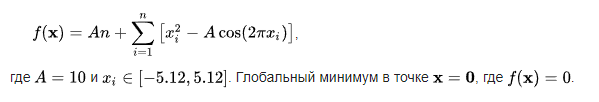

In [14]:
def Rastrigin_func(x,y):
    return 20+(x**2-10*np.cos(2*np.pi*x))+(y**2-10*np.cos(2*np.pi*y)) 

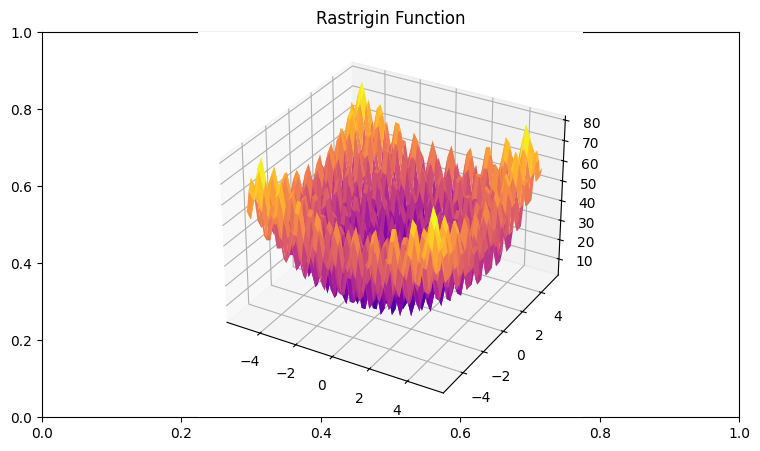

In [15]:
Plot_func(Rastrigin_func,-5.12,5.12,-5.12,5.12,"Rastrigin Function") 


**Генетический алгоритм**

In [16]:
best_chromosome, best_fitness = GA_Find_GlobalMinima(obj_func = Rastrigin_func, population_size= 470, gene_min = -5.12, gene_max = 5.12, 
                     no_generations = 430, mutation_ratio = 0.5, var = 1, 
                     target_min = Rastrigin_func(0, 0), target_location = "(0, 0)") 

print(f"Координаты хромосомы: {best_chromosome}, Минимум: {best_fitness}")

Координаты хромосомы: [-0.00900765  0.00975665  0.03497229], Минимум: 0.034972293580754155


**Гибридный алгоритм**

In [17]:
best_chromosome, best_fitness = hybrid_optimizer(obj_func=Rastrigin_func, population_size=470, 
                                                            gene_min=-5, gene_max=5, no_generations=430,
                                                            mutation_ratio=0.5, var=1, 
                                                            target_min=Rastrigin_func(0, 0), target_location="(0, 0)",
                                                            initial_temperature=350, alpha=0.6)

print("Минимум:", best_fitness, "Координаты:", best_chromosome)

Минимум: 0.037625972403343866 Координаты: [0.007205388779133029, 0.01173916301192385, 0.037625972403343866]


<h2><center>Функция Химмельблау</center></h2> 

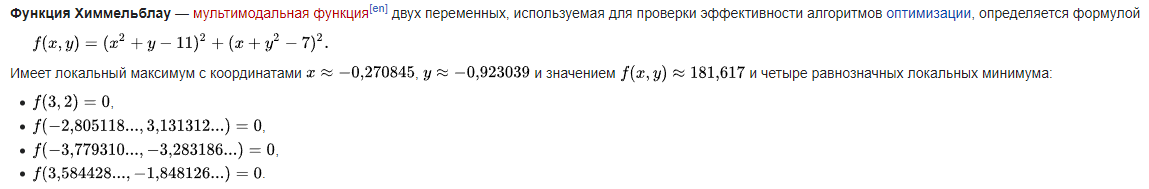

In [18]:
def Himmelblau_func(x,y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

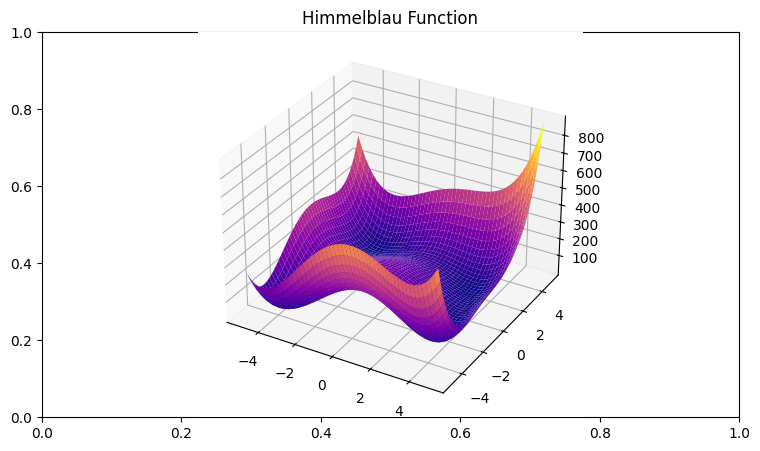

In [19]:
Plot_func(Himmelblau_func,-5,5,-5,5,"Himmelblau Function") 

**Генетический алгоритм** 

In [20]:
best_chromosome, best_fitness = GA_Find_GlobalMinima(obj_func = Himmelblau_func, population_size= 230, gene_min = -5, gene_max = 5, 
                     no_generations = 940, mutation_ratio = 0.4, var = 1, 
                     target_min = '0', target_location = "(3, 2); (-2.805118, 3.131312); (-3.779310, -3.283186); (3.584428, -1.848126)") 


print(f"Координаты хромосомы: {best_chromosome}, Минимум: {best_fitness}")

Координаты хромосомы: [-2.80602695e+00  3.12993883e+00  1.04321881e-04], Минимум: 0.00010432188122151506


**Гибридный алгоритм** 

In [21]:
best_chromosome, best_fitness = hybrid_optimizer(obj_func=Himmelblau_func, population_size=230, 
                                                            gene_min=-5, gene_max=5, no_generations=940,
                                                            mutation_ratio=0.4, var=1, 
                                                            target_min='0', target_location="(3, 2); (-2.805118, 1, 3.131312); (-3.779310, -3.283186); (3.584428, -1.848126)",
                                                            initial_temperature=280, alpha=0.7)

print("Минимум:", best_fitness, "Координаты:", best_chromosome)

Минимум: 0.0015658134020595498 Координаты: [2.99919130e+00 1.99092216e+00 1.56581340e-03]


<h2><center>Функция Розенброка</center></h2> 

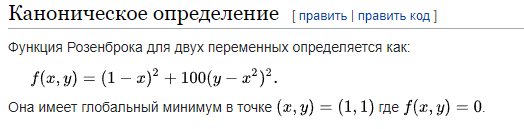

In [22]:
def Rosenbrock_func(x,y):
    return 100*(y-x**2)**2+(x-1)**2 

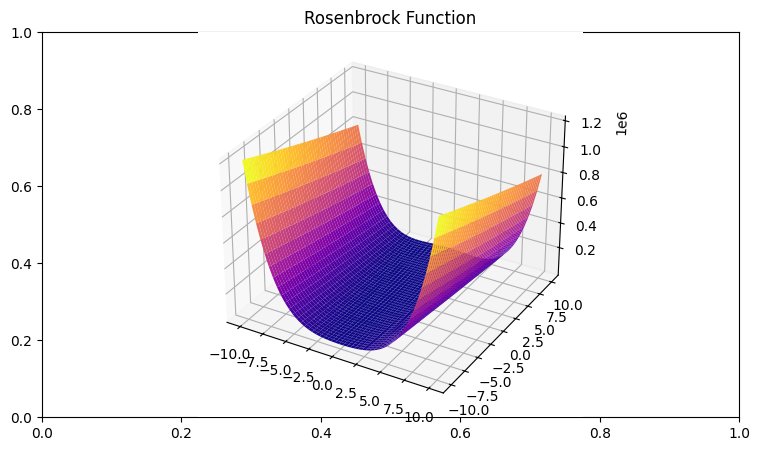

In [23]:
Plot_func(Rosenbrock_func,-10,10,-10,10,"Rosenbrock Function") 

**Генетический алгоритм** 

In [24]:
best_chromosome, best_fitness = GA_Find_GlobalMinima(obj_func = Rosenbrock_func, population_size= 470, gene_min = -10, gene_max = 10, 
                     no_generations = 480, mutation_ratio = 0.4, var = 1, 
                     target_min = '0', target_location = "(1, 1)") 

print("Минимум:", best_fitness, "Координаты:", best_chromosome)

Минимум: 0.014794472374278913 Координаты: [1.10082297 1.20500739 0.01479447]


**Гибридный алгоритм** 

In [25]:
best_chromosome, best_fitness = hybrid_optimizer(obj_func=Rosenbrock_func, population_size=470, 
                                                            gene_min=-10, gene_max= 10, no_generations=480,
                                                            mutation_ratio=0.4, var=1, 
                                                            target_min=Rosenbrock_func(1, 1), target_location="(1, 1)",
                                                            initial_temperature=463, alpha=0.8)

print("Минимум:", best_fitness, "Координаты:", best_chromosome)

Минимум: 4.0489428043888066e-05 Координаты: [0.9938127188244896, 0.9875151610282955, 4.0489428043888066e-05]


<h2><center>Функция Подставка для яиц</center></h2> 

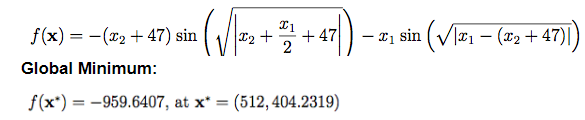

In [26]:
def Eggholder_func(x,y):
    return -(y+47)*np.sin(np.sqrt(np.abs(y+y/2+47)))-x*np.sin(np.sqrt(np.abs(x-(y+47)))) 

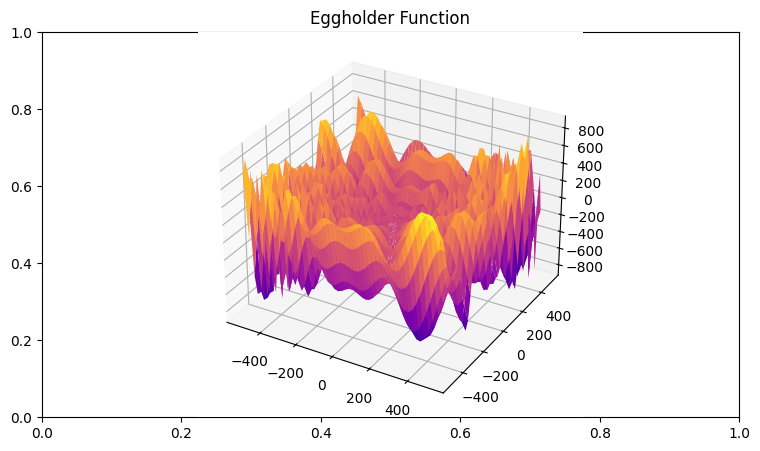

In [27]:
Plot_func(Eggholder_func,-512,512,-512,512,"Eggholder Function") 

**Генетический алгоритм** 

In [28]:
best_chromosome, best_fitness = GA_Find_GlobalMinima(obj_func = Eggholder_func, population_size= 580, gene_min = -512, gene_max = 512, 
                     no_generations = 740, mutation_ratio = 0.5, var = 2, 
                     target_min = "-959.6407",target_location = "(512, 404.2319)") 

print("Минимум:", best_fitness, "Координаты:", best_chromosome)

Минимум: -987.260634861447 Координаты: [ 501.6662155   452.32651758 -987.26063486]


**Гибридный алгоритм** 

In [29]:
best_chromosome, best_fitness = hybrid_optimizer(obj_func=Eggholder_func, population_size=580,
                                                            gene_min=-512, gene_max=512, no_generations=740,
                                                            mutation_ratio=0.5, var=2, 
                                                            target_min="-959.6407", target_location="(512,404.2319)",
                                                            initial_temperature=1000, alpha=0.6)

print("Минимум:", best_fitness, "Координаты:", best_chromosome)

Минимум: -988.9834363700925 Координаты: [ 496.86284961  447.4538615  -988.98343637]


<h2><center>Статистика</center></h2> 

Выполним запуск генетического и гибридного алгоритмов несколько раз для каждой функции и вычислим СКО на разном числе итераций, тем самым проверим какой из алгоритмов (гибридный или генетический) дает больший разброс решений

**Растригина**

Результаты, полученные для **функции Растригина при случайных гиперпараметрах:**

population_size=200, no_generations=300, mutation_ratio=0.5, var=2, initial_temperature=1000, alpha=0.95
|Кол-во итераций|СКО Генетического алгоритма|СКО Гибридного алгоритма|СКО ААА|
|---------------|---------------------------|------------------------|-------|
|25             |0.12                       |0.088                   |0.297  |
|50             |0.151                      |0.076                   |0.106  |
|75             |0.127                      |0.057                   |-      |
|100            |0.119                      |0.061                   |-      |
|200            |0.123                      |0.069                   |-      |

Результаты, полученные для **функции Растригина при оптимальных гиперпараметрах:**

population_size=470, no_generations=430, mutation_ratio=0.5, var=1, initial_temperature=350, alpha=0.6

|Кол-во итераций|СКО Генетического алгоритма|СКО Гибридного алгоритма|СКО ААА|
|---------------|---------------------------|------------------------|-------|
|25             |0.033                      |0.019                   |0.297  |
|50             |0.028                      |0.032                   |0.106  |
|75             |0.036                      |0.027                   |-      |
|100            |                      |                   |-      |
|200            |                      |                   |-      |    

**Химмельблау**

Результаты, полученные для **функции Химмельблау при случайных гиперпараметрах:**
    
population_size=100, no_generations=700, mutation_ratio=0.1, var=1, initial_temperature=100, alpha=0.95, initial_temperature=1000, alpha=0.95
                     
|Кол-во итераций|СКО Генетического алгоритма|СКО Гибридного алгоритма|СКО ААА|
|---------------|---------------------------|------------------------|-------|
|25             |0.00507                    |0.000108                |0.3102 |
|50             |0.00340                    |0.000170                |0.2997 |
|75             |0.00533                    |0.00025                 |-      |
|100            |0.00679                    |0.000268                |-      |
|200            |0.00593                    |0.000297                |-      |


Результаты, полученные для **функции Химмельблау при оптимальных гиперпараметрах:**
    
population_size=230, no_generations=940, mutation_ratio=0.4, var=1, initial_temperature=280, alpha=0.7
                     
|Кол-во итераций|СКО Генетического алгоритма|СКО Гибридного алгоритма|СКО ААА|
|---------------|---------------------------|------------------------|-------|
|25             |0.00119                    |0.00077                 |0.3102 |
|50             |0.00125                    |0.00067                 |0.2997 |
|75             |0.00117                    |0.00079                 |-      |
|100            |                           |                        |-      |
|200            |                           |                        |-      |    

**Розенброка**

Результаты, полученные для **функции Розенброка при случайных гиперпараметрах:**

population_size=100, no_generations=700, mutation_ratio=0.3, var=1, initial_temperature=100, alpha=0.8
                     
|Кол-во итераций|СКО Генетического алгоритма|СКО Гибридного алгоритма|СКО ААА|
|---------------|---------------------------|------------------------|-------|
|25             |0.0211                     |0.0213                  |0.047  |
|50             |0.0274                     |0.0079                  |0.072  |
|75             |0.0186                     |0.0194                  |-      |
|100            |0.0199                     |0.0131                  |-      |
|200            |0.0218                     |0.0102                  |-      |  

Результаты, полученные для **функции Розенброка при оптимальных гиперпараметрах:**

population_size=470, no_generations=480, mutation_ratio=0.4, var=1, initial_temperature=463, alpha=0.8                                                                               
|Кол-во итераций|СКО Генетического алгоритма|СКО Гибридного алгоритма|СКО ААА|
|---------------|---------------------------|------------------------|-------|
|25             |0.0087                     |0.0057                  |0.047  |
|50             |0.0050                     |0.0041                  |0.072  |
|75             |0.0069                     |0.0031                  |-      |
|100            |                           |                        |-      |
|200            |                           |                        |-      |

**Подставка для яиц**

Результаты, полученные для **функции Подставки для яиц при случайных гиперпараметрах:**

population_size=200, no_generations=300, mutation_ratio=0.5, var=2, initial_temperature=1000, alpha=0.6

|Кол-во итераций|СКО Генетического алгоритма|СКО Гибридного алгоритма|СКО ААА|
|---------------|---------------------------|------------------------|-------|
|25             |11.84                      |0.26                    |94.89  |
|50             |14.27                      |0.62                    |136.017|
|75             |20.11                      |12.46                   |-      |
|100            |19.09                      |12.83                   |-      |
|200            |18.32                      |8.99                    |-      |

Результаты, полученные для **функции Подставки для яиц при оптимальных гиперпараметрах:**
    
population_size=580, no_generations=740, mutation_ratio=0.5, var=2, initial_temperature=1000, alpha=0.6
                                                            
|Кол-во итераций|СКО Генетического алгоритма|СКО Гибридного алгоритма|СКО ААА|
|---------------|---------------------------|------------------------|-------|
|25             |2.25                       |1.73                    |94.89  |
|50             |2.21                       |1.87                    |136.017|
|75             |2.65                       |1.41                    |-      |
|100            |-                          |-                       |-      |
|200            |-                          |-                       |-      |    

Выводы: 

- Гибридный алгоритм дает меньший разброс решений в сравнении с генетическим алгоритмом; 
- Алгоритм ААА показал результаты хуже, чем генетический алгоритм или гибридный, как по скорости работы, так и по рассчитанному СКО.

### Подбор гиперпараметров с Optuna

### Подбор гиперпараметров генетического алгоритма на функции Розенброка

In [30]:
# import optuna
# import numpy as np

# def objective(trial):
#     # Define the hyperparameters to search
#     population_size = trial.suggest_int('population_size', 10, 1000, step=10)
#     mutation_ratio = trial.suggest_float('mutation_ratio', 0.1, 1, step = 0.1)
#     initial_temperature = trial.suggest_float('initial_temperature', 100, 1000, step=20)
#     alpha = trial.suggest_float('alpha', 0.5, 1, step = 0.1)
#     # gene_min = trial.suggest_float('gene_min', -500, 0, step = 10)
#     # gene_max = trial.suggest_float('gene_max', 0, 500, step = 10)
#     no_generations = trial.suggest_int('no_generations', 20, 1000, step=20)
#     var = trial.suggest_int('var', 1, 2)
#     gene_range = trial.suggest_float('gene_range', 0.01, 0.5, step = 0.01)
#     fit_range = trial.suggest_float('fit_range', 0.01, 0.5, step = 0.01)

#     # Call the hybrid_optimizer function with the suggested hyperparameters
#     best_chromosome, best_fitness = hybrid_optimizer(obj_func=Eggholder_func, 
#                                                      population_size=population_size, 
#                                                      gene_min= -512, gene_max= 512, 
#                                                      no_generations=no_generations,
#                                                      mutation_ratio=mutation_ratio, 
#                                                      var = var, 
#                                                      target_min='0', 
#                                                      target_location="(3, 2); (-2.805118, 1, 3.131312); (-3.779310, -3.283186); (3.584428, -1.848126)",
#                                                      initial_temperature=initial_temperature, 
#                                                      alpha=alpha, gene_range= gene_range, fit_range = 0)
    
#     return best_fitness

# print("Минимум:", best_fitness, "Координаты:", best_chromosome)

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=500)

# df = study.trials_dataframe()

# best_params = study.best_params
# best_fitness = study.best_value

# best_params['best_value'] = best_fitness  # Создаем новую строку для лучших параметров

# # Преобразуем словарь лучших параметров в DataFrame и добавляем его в основной DataFrame
# best_params_df = pd.DataFrame([best_params])
# best_params_df['record_type'] = 'best_result'
# df = pd.concat([df, best_params_df], ignore_index=True)

# # Записываем DataFrame в CSV файл
# df.to_csv('csv_files/rosenbrock1.csv', index=False)

### Подбор гиперпараметров генетического алгоритма на функции "Подставки для яиц"

In [31]:
# import optuna
# import numpy as np

# def objective(trial):
#     # Define the hyperparameters to search
#     population_size = trial.suggest_int('population_size', 10, 500, step = 20)
#     mutation_ratio = trial.suggest_float('mutation_ratio', 0.1, 1, step = 0.1)
#     no_generations = trial.suggest_int('no_generations', 20, 1000, step=20)
#     var = trial.suggest_int('var', 1, 2)


#     # Call the hybrid_optimizer function with the suggested hyperparameters
#     best_chromosome, best_fitness = GA_Find_GlobalMinima(obj_func=Eggholder_func, 
#                                                      population_size=population_size, 
#                                                      gene_min= -512, gene_max= 512, 
#                                                      no_generations=no_generations,
#                                                      mutation_ratio=mutation_ratio, 
#                                                      var = var, 
#                                                      target_min='0', 
#                                                      target_location="(3, 2); (-2.805118, 1, 3.131312); (-3.779310, -3.283186); (3.584428, -1.848126)")
    
#     return best_fitness

# print("Минимум:", best_fitness, "Координаты:", best_chromosome)

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=500)

# df = study.trials_dataframe()

# best_params = study.best_params
# best_fitness = study.best_value

# best_params['best_value'] = best_fitness  # Создаем новую строку для лучших параметров

# # Преобразуем словарь лучших параметров в DataFrame и добавляем его в основной DataFrame
# best_params_df = pd.DataFrame([best_params])
# best_params_df['record_type'] = 'best_result'
# df = pd.concat([df, best_params_df], ignore_index=True)

# # Записываем DataFrame в CSV файл
# df.to_csv('csv_files/eggholder.csv', index=False)

### Подбор гиперпараметров генетического алгоритма на функции Растригина

In [32]:
# import optuna
# import numpy as np

# def objective(trial):
#     # Define the hyperparameters to search
#     population_size = trial.suggest_int('population_size', 10, 500, step= 20)
#     mutation_ratio = trial.suggest_float('mutation_ratio', 0.1, 1, step = 0.1)
#     no_generations = trial.suggest_int('no_generations', 20, 1000, step=20)
#     var = trial.suggest_int('var', 1, 2)


#     # Call the hybrid_optimizer function with the suggested hyperparameters
#     best_chromosome, best_fitness = GA_Find_GlobalMinima(obj_func=Rastrigin_func, 
#                                                      population_size=population_size, 
#                                                      gene_min= -5.12, gene_max= 5.12, 
#                                                      no_generations=no_generations,
#                                                      mutation_ratio=mutation_ratio, 
#                                                      var = var, 
#                                                      target_min='0', 
#                                                      target_location="(3, 2); (-2.805118, 1, 3.131312); (-3.779310, -3.283186); (3.584428, -1.848126)")
    
#     return best_fitness

# print("Минимум:", best_fitness, "Координаты:", best_chromosome)

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=500)

# df = study.trials_dataframe()

# best_params = study.best_params
# best_fitness = study.best_value

# best_params['best_value'] = best_fitness  # Создаем новую строку для лучших параметров

# # Преобразуем словарь лучших параметров в DataFrame и добавляем его в основной DataFrame
# best_params_df = pd.DataFrame([best_params])
# best_params_df['record_type'] = 'best_result'
# df = pd.concat([df, best_params_df], ignore_index=True)

# # Записываем DataFrame в CSV файл
# df.to_csv('csv_files/rastrigin.csv', index=False)

### Подбор гиперпараметров генетического алгоритма на функции Химмельблау

In [33]:
# import optuna
# import numpy as np

# def objective(trial):
#     # Define the hyperparameters to search
#     population_size = trial.suggest_int('population_size', 10, 500, step=20)
#     mutation_ratio = trial.suggest_float('mutation_ratio', 0.1, 1, step = 0.1)
#     no_generations = trial.suggest_int('no_generations', 20, 1000, step=40)
#     var = trial.suggest_int('var', 1, 2)


#     # Call the hybrid_optimizer function with the suggested hyperparameters
#     best_chromosome, best_fitness = GA_Find_GlobalMinima(obj_func=Himmelblau_func, 
#                                                      population_size=population_size, 
#                                                      gene_min= -5, gene_max= 5, 
#                                                      no_generations=no_generations,
#                                                      mutation_ratio=mutation_ratio, 
#                                                      var = var, 
#                                                      target_min='0', 
#                                                      target_location="(3, 2); (-2.805118, 1, 3.131312); (-3.779310, -3.283186); (3.584428, -1.848126)")
    
#     return best_fitness

# print("Минимум:", best_fitness, "Координаты:", best_chromosome)

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=500)

# df = study.trials_dataframe()

# best_params = study.best_params
# best_fitness = study.best_value

# best_params['best_value'] = best_fitness  # Создаем новую строку для лучших параметров

# # Преобразуем словарь лучших параметров в DataFrame и добавляем его в основной DataFrame
# best_params_df = pd.DataFrame([best_params])
# best_params_df['record_type'] = 'best_result'
# df = pd.concat([df, best_params_df], ignore_index=True)

# # Записываем DataFrame в CSV файл
# df.to_csv('csv_files/himmelblau.csv', index=False)

In [34]:
# import optuna
# import numpy as np

# def objective(trial):
#     # Define the hyperparameters to search
#     population_size = trial.suggest_int('population_size', 10, 500, step=20)
#     mutation_ratio = trial.suggest_float('mutation_ratio', 0.1, 1, step = 0.1)
#     no_generations = trial.suggest_int('no_generations', 20, 1000, step=40)
#     gene_min = trial.suggest_int('gene_min', -500, 0, step = 20)
#     gene_max = trial.suggest_int('gene_max', 0, 500, step = 20)
#     var = trial.suggest_int('var', 1, 2)


#     # Call the hybrid_optimizer function with the suggested hyperparameters
#     best_chromosome, best_fitness = GA_Find_GlobalMinima(obj_func=Rosenbrock_func, 
#                                                      population_size=population_size, 
#                                                      gene_min= -5.12, gene_max= 5.12, 
#                                                      no_generations=no_generations,
#                                                      mutation_ratio=mutation_ratio, 
#                                                      var = var, 
#                                                      target_min='0', 
#                                                      target_location="(3, 2); (-2.805118, 1, 3.131312); (-3.779310, -3.283186); (3.584428, -1.848126)")
    
#     return best_fitness

# print("Минимум:", best_fitness, "Координаты:", best_chromosome)

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=500)

# df = study.trials_dataframe()

# best_params = study.best_params
# best_fitness = study.best_value

# best_params['best_value'] = best_fitness  # Создаем новую строку для лучших параметров

# # Преобразуем словарь лучших параметров в DataFrame и добавляем его в основной DataFrame
# best_params_df = pd.DataFrame([best_params])
# best_params_df['record_type'] = 'best_result'
# df = pd.concat([df, best_params_df], ignore_index=True)

# # Записываем DataFrame в CSV файл
# df.to_csv('csv_files/rosenbrock.csv', index=False)

### Подбор гиперпараметров гибридного алгоритма на функции Растригина

In [35]:
# import optuna
# import csv

# def objective(trial):
#     # Определяем пространство поиска гиперпараметров
#     population_size = trial.suggest_int('population_size', 100, 500)
#     no_generations = trial.suggest_int('no_generations', 200, 600)
#     mutation_ratio = trial.suggest_float('mutation_ratio', 0.1, 0.9)
#     var = trial.suggest_int('var', 1, 2)
#     initial_temperature = trial.suggest_int('initial_temperature', 50, 500)
#     alpha = trial.suggest_float('alpha', 0.1, 0.9)

#     # Запускаем ваш оптимизационный алгоритм с выбранными гиперпараметрами
#     best_chromosome, best_fitness = hybrid_optimizer(obj_func=Rastrigin_func, population_size=population_size, 
#                                                      gene_min=-5.12, gene_max=5.12, no_generations=no_generations,
#                                                      mutation_ratio=mutation_ratio, var=var, 
#                                                      target_min=Rastrigin_func(0, 0), target_location="(0, 0)",
#                                                      initial_temperature=initial_temperature, alpha=alpha)

#     # Возвращаем значение целевой функции для оптимизации Optuna
#     return best_fitness

# def optimize_and_save():
#     # Создание исследования и его оптимизация
#     study = optuna.create_study(direction='minimize')
#     study.optimize(objective, n_trials=1000)

#     # Сохраняем детали всех испытаний в DataFrame
#     df = study.trials_dataframe()

#     # Добавляем лучшие параметры и результат в DataFrame
#     best_params = study.best_params
#     best_value = study.best_value
#     best_params['best_value'] = best_value  # Создаем новую строку для лучших параметров

#     # Преобразуем словарь лучших параметров в DataFrame и добавляем его в основной DataFrame
#     best_params_df = pd.DataFrame([best_params])
#     best_params_df['record_type'] = 'best_result'
#     df = pd.concat([df, best_params_df], ignore_index=True)

#     # Записываем DataFrame в CSV файл
#     df.to_csv('csv_files/rastrigin_hybrid.csv', index=False)

# if __name__ == "__main__":
#     optimize_and_save()


### Подбор гиперпараметров гибридного алгоритма на функции Химмельблау

In [36]:
# import optuna
# import csv

# def objective(trial):
#     # Определяем пространство поиска гиперпараметров
#     population_size = trial.suggest_int('population_size', 100, 500)
#     no_generations = trial.suggest_int('no_generations', 200, 600)
#     mutation_ratio = trial.suggest_float('mutation_ratio', 0.1, 0.9)
#     var = trial.suggest_int('var', 1, 2)
#     initial_temperature = trial.suggest_int('initial_temperature', 50, 1000)
#     alpha = trial.suggest_float('alpha', 0.1, 0.9)

#     # Запускаем ваш оптимизационный алгоритм с выбранными гиперпараметрами
#     best_chromosome, best_fitness = hybrid_optimizer(obj_func=Himmelblau_func, population_size=population_size, 
#                                                      gene_min=-5, gene_max=5, no_generations=no_generations,
#                                                      mutation_ratio=mutation_ratio, var=var, 
#                                                      target_min=Himmelblau_func(0, 0), target_location="(0, 0)",
#                                                      initial_temperature=initial_temperature, alpha=alpha)

#     # Возвращаем значение целевой функции для оптимизации Optuna
#     return best_fitness

# def optimize_and_save():
#     # Создание исследования и его оптимизация
#     study = optuna.create_study(direction='minimize')
#     study.optimize(objective, n_trials=500)

#     # Сохраняем детали всех испытаний в DataFrame
#     df = study.trials_dataframe()

#     # Добавляем лучшие параметры и результат в DataFrame
#     best_params = study.best_params
#     best_value = study.best_value
#     best_params['best_value'] = best_value  # Создаем новую строку для лучших параметров

#     # Преобразуем словарь лучших параметров в DataFrame и добавляем его в основной DataFrame
#     best_params_df = pd.DataFrame([best_params])
#     best_params_df['record_type'] = 'best_result'
#     df = pd.concat([df, best_params_df], ignore_index=True)

#     # Записываем DataFrame в CSV файл
#     df.to_csv('csv_files/himmelblau_hybrid.csv', index=False)

# if __name__ == "__main__":
#     optimize_and_save()


### Подбор гиперпараметров гибридного алгоритма на функции Розенброка

In [37]:
# import optuna
# import csv

# def objective(trial):
#     # Определяем пространство поиска гиперпараметров
#     population_size = trial.suggest_int('population_size', 100, 500)
#     gene_min = trial.suggest_int('gene_min', -500, 0)
#     gene_max = trial.suggest_int('gene_max', 0, 500)
#     no_generations = trial.suggest_int('no_generations', 200, 600)
#     mutation_ratio = trial.suggest_float('mutation_ratio', 0.1, 0.9)
#     var = trial.suggest_int('var', 1, 2)
#     initial_temperature = trial.suggest_int('initial_temperature', 50, 1000)
#     alpha = trial.suggest_float('alpha', 0.1, 0.9)

#     # Запускаем ваш оптимизационный алгоритм с выбранными гиперпараметрами
#     best_chromosome, best_fitness = hybrid_optimizer(obj_func=Rosenbrock_func, population_size=population_size, 
#                                                      gene_min = gene_min, gene_max= gene_max, no_generations=no_generations,
#                                                      mutation_ratio=mutation_ratio, var=var, 
#                                                      target_min=Rosenbrock_func(0, 0), target_location="(0, 0)",
#                                                      initial_temperature=initial_temperature, alpha=alpha)

#     # Возвращаем значение целевой функции для оптимизации Optuna
#     return best_fitness

# def optimize_and_save():
#     # Создание исследования и его оптимизация
#     study = optuna.create_study(direction='minimize')
#     study.optimize(objective, n_trials=500)

#     # Сохраняем детали всех испытаний в DataFrame
#     df = study.trials_dataframe()

#     # Добавляем лучшие параметры и результат в DataFrame
#     best_params = study.best_params
#     best_value = study.best_value
#     best_params['best_value'] = best_value  # Создаем новую строку для лучших параметров

#     # Преобразуем словарь лучших параметров в DataFrame и добавляем его в основной DataFrame
#     best_params_df = pd.DataFrame([best_params])
#     best_params_df['record_type'] = 'best_result'
#     df = pd.concat([df, best_params_df], ignore_index=True)

#     # Записываем DataFrame в CSV файл
#     df.to_csv('csv_files/rosenbrock_hybrid.csv', index=False)

# if __name__ == "__main__":
#     optimize_and_save()


### Подбор гиперпараметров гибридного алгоритма на функции "Подставки для яиц"

In [38]:
# import optuna
# import csv

# def objective(trial):
#     # Определяем пространство поиска гиперпараметров
#     population_size = trial.suggest_int('population_size', 100, 500)
#     no_generations = trial.suggest_int('no_generations', 200, 600)
#     mutation_ratio = trial.suggest_float('mutation_ratio', 0.1, 0.9)
#     var = trial.suggest_int('var', 1, 2)
#     initial_temperature = trial.suggest_int('initial_temperature', 50, 1000)
#     alpha = trial.suggest_float('alpha', 0.1, 0.9)

#     # Запускаем ваш оптимизационный алгоритм с выбранными гиперпараметрами
#     best_chromosome, best_fitness = hybrid_optimizer(obj_func= Eggholder_func, population_size=population_size, 
#                                                      gene_min = -512, gene_max= 512, no_generations=no_generations,
#                                                      mutation_ratio=mutation_ratio, var=var, 
#                                                      target_min= Eggholder_func(0, 0), target_location="(0, 0)",
#                                                      initial_temperature=initial_temperature, alpha=alpha)

#     # Возвращаем значение целевой функции для оптимизации Optuna
#     return best_fitness

# def optimize_and_save():
#     # Создание исследования и его оптимизация
#     study = optuna.create_study(direction='minimize')
#     study.optimize(objective, n_trials=500)

#     # Сохраняем детали всех испытаний в DataFrame
#     df = study.trials_dataframe()

#     # Добавляем лучшие параметры и результат в DataFrame
#     best_params = study.best_params
#     best_value = study.best_value
#     best_params['best_value'] = best_value  # Создаем новую строку для лучших параметров

#     # Преобразуем словарь лучших параметров в DataFrame и добавляем его в основной DataFrame
#     best_params_df = pd.DataFrame([best_params])
#     best_params_df['record_type'] = 'best_result'
#     df = pd.concat([df, best_params_df], ignore_index=True)

#     # Записываем DataFrame в CSV файл
#     df.to_csv('csv_files/eggholder_hybrid.csv', index=False)

# if __name__ == "__main__":
#     optimize_and_save()

#### Полученные значение приведены ниже в таблице с указанием в конце наилучшего результата:

#### Гиперпараметры для функции Растригина:

In [39]:
# Загрузка данных из CSV файла
df = pd.read_csv('csv_files/rastrigin_hybrid.csv')

columns = [
    'datetime_start', 'datetime_complete', 'params_population_size',
    'params_no_generations', 'params_mutation_ratio', 'params_var',  'params_initial_temperature', 
    'params_alpha', 'population_size', 'no_generations','mutation_ratio','var','initial_temperature','alpha','best_value', 'record_type'
]

print(tabulate(df[columns], headers='keys', tablefmt='psql'))




+------+----------------------------+----------------------------+--------------------------+-------------------------+-------------------------+--------------+------------------------------+----------------+-------------------+------------------+------------------+-------+-----------------------+------------+---------------+---------------+
|      | datetime_start             | datetime_complete          |   params_population_size |   params_no_generations |   params_mutation_ratio |   params_var |   params_initial_temperature |   params_alpha |   population_size |   no_generations |   mutation_ratio |   var |   initial_temperature |      alpha |    best_value | record_type   |
|------+----------------------------+----------------------------+--------------------------+-------------------------+-------------------------+--------------+------------------------------+----------------+-------------------+------------------+------------------+-------+-----------------------+------------+-

#### Гиперпараметры для функции Химмельблау:

In [40]:
from tabulate import tabulate
# Загрузка данных из CSV файла
df = pd.read_csv('csv_files/himmelblau_hybrid.csv')

columns = [
    'datetime_start', 'datetime_complete', 'params_population_size',
    'params_no_generations', 'params_mutation_ratio', 'params_var',  'params_initial_temperature', 
    'params_alpha', 'population_size', 'no_generations','mutation_ratio','var','initial_temperature','alpha','best_value', 'record_type'
]

print(tabulate(df[columns], headers='keys', tablefmt='psql'))




+-----+----------------------------+----------------------------+--------------------------+-------------------------+-------------------------+--------------+------------------------------+----------------+-------------------+------------------+------------------+-------+-----------------------+------------+---------------+---------------+
|     | datetime_start             | datetime_complete          |   params_population_size |   params_no_generations |   params_mutation_ratio |   params_var |   params_initial_temperature |   params_alpha |   population_size |   no_generations |   mutation_ratio |   var |   initial_temperature |      alpha |    best_value | record_type   |
|-----+----------------------------+----------------------------+--------------------------+-------------------------+-------------------------+--------------+------------------------------+----------------+-------------------+------------------+------------------+-------+-----------------------+------------+----

#### Гиперпараметры для функции Розенброка:

In [41]:
from tabulate import tabulate
# Загрузка данных из CSV файла
df = pd.read_csv('csv_files/rosenbrock_hybrid.csv')

columns = [
    'datetime_start', 'datetime_complete', 'params_population_size',
    'params_no_generations', 'params_mutation_ratio', 'params_var',  'params_initial_temperature', 
    'params_alpha', 'population_size', 'no_generations','mutation_ratio','var','initial_temperature','alpha','best_value', 'record_type'
]

print(tabulate(df[columns], headers='keys', tablefmt='psql'))




+-----+----------------------------+----------------------------+--------------------------+-------------------------+-------------------------+--------------+------------------------------+----------------+-------------------+------------------+------------------+-------+-----------------------+------------+---------------+---------------+
|     | datetime_start             | datetime_complete          |   params_population_size |   params_no_generations |   params_mutation_ratio |   params_var |   params_initial_temperature |   params_alpha |   population_size |   no_generations |   mutation_ratio |   var |   initial_temperature |      alpha |    best_value | record_type   |
|-----+----------------------------+----------------------------+--------------------------+-------------------------+-------------------------+--------------+------------------------------+----------------+-------------------+------------------+------------------+-------+-----------------------+------------+----

#### Гиперпараметры для функции Подставки для яиц:

In [42]:
from tabulate import tabulate
# Загрузка данных из CSV файла
df = pd.read_csv('csv_files/eggholder_hybrid.csv')

columns = [
    'datetime_start', 'datetime_complete', 'params_population_size',
    'params_no_generations', 'params_mutation_ratio', 'params_var',  'params_initial_temperature', 
    'params_alpha', 'population_size', 'no_generations','mutation_ratio','var','initial_temperature','alpha','best_value', 'record_type'
]

print(tabulate(df[columns], headers='keys', tablefmt='psql'))




+-----+----------------------------+----------------------------+--------------------------+-------------------------+-------------------------+--------------+------------------------------+----------------+-------------------+------------------+------------------+-------+-----------------------+-----------+--------------+---------------+
|     | datetime_start             | datetime_complete          |   params_population_size |   params_no_generations |   params_mutation_ratio |   params_var |   params_initial_temperature |   params_alpha |   population_size |   no_generations |   mutation_ratio |   var |   initial_temperature |     alpha |   best_value | record_type   |
|-----+----------------------------+----------------------------+--------------------------+-------------------------+-------------------------+--------------+------------------------------+----------------+-------------------+------------------+------------------+-------+-----------------------+-----------+---------

**Список использованных источников:** 

1. Метод отжига: 
- https://www.mql5.com/ru/articles/4150 
- https://masters.donntu.ru/2013/fknt/niftaliev/library/source.pdf

2. Использованные ссылки для написания генетического алгоритма: 
- https://habr.com/ru/articles/498308/ 
- https://habr.com/ru/articles/551890/ (текстовое описание брали за основу)


3. Идея использования гибридного алгоритма: 
- https://github.com/rayjasson98/Hybrid-Genetic-Algorithm-Simulated-Annealing-for-Presentation-Scheduling/tree/master 